In [38]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [32]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    '''fetch all out test data from directory
    folder path is a list of n directories for n class classification '''

    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

#     total_images = train_data.n  
#     steps = total_images//batch_size 
#     xtrain , ytrain = [] , []
#     for i in range(steps):
#         a , b = train_data.next()
#         xtrain.extend(a) 
#         ytrain.extend(b)

#     total_images = val_data.n  
#     steps = total_images//batch_size 
#     xval , yval = [] , []
#     for i in range(steps):
#         a , b = val_data.next()
#         xval.extend(a) 
#         yval.extend(b)

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames

In [33]:
folder_path = './COVID-19_Radiography_Dataset/'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [34]:
class_names = train_data.class_indices
print(class_names)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [35]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [36]:
images,labels = next(train_data)
indices,image_path = get_filepath_from_generator(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

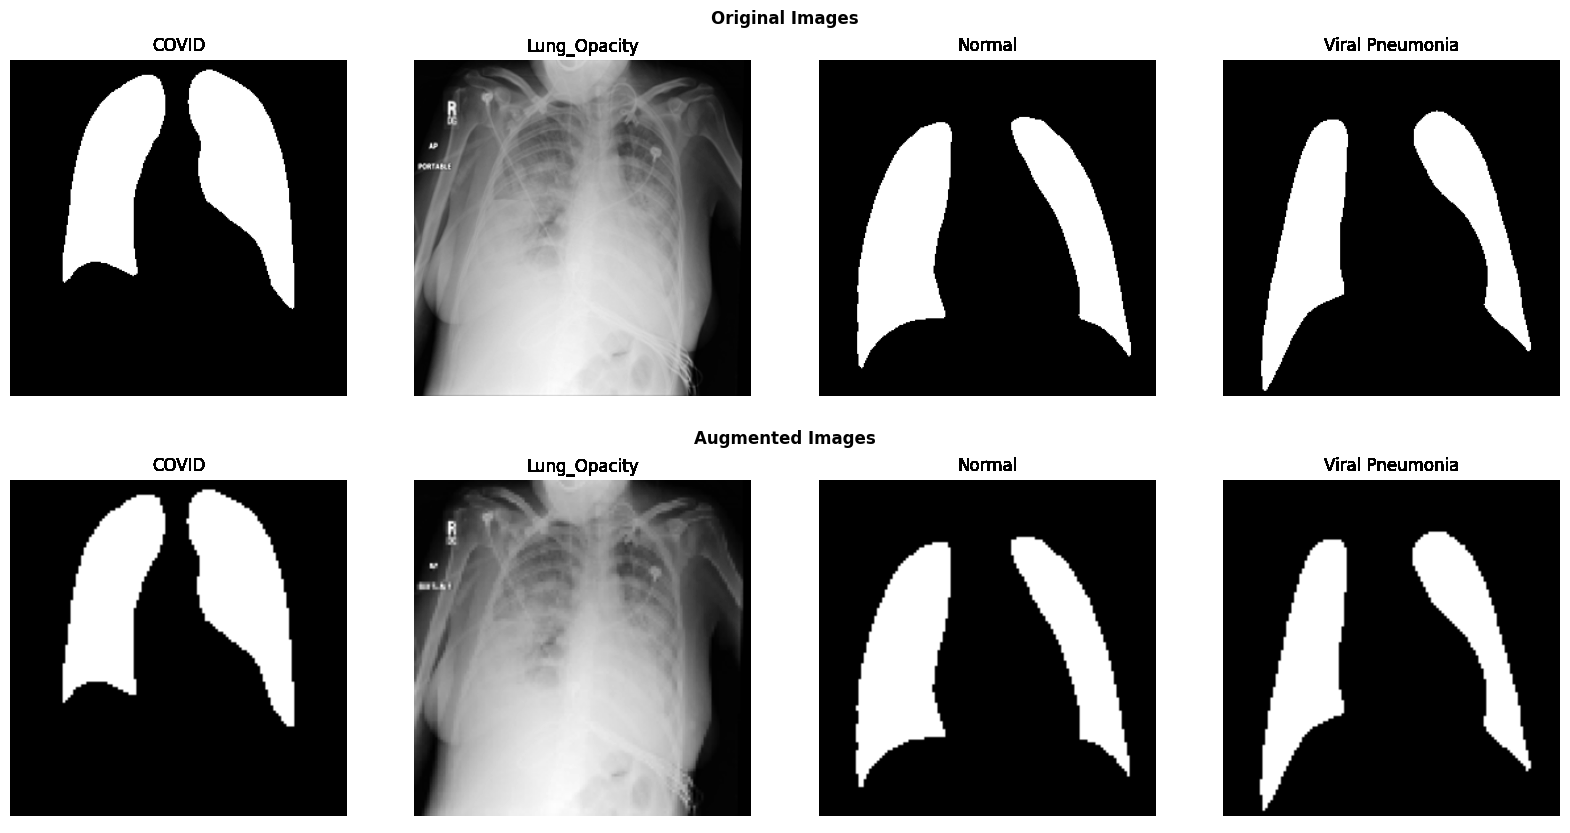

In [37]:
#Lets visualize the augmented images
fig, big_axes = plt.subplots( figsize=(20, 10) , nrows=2, ncols=1, sharey=True) 
titles = ['Original Images','Augmented Images']
for title, big_ax in zip(titles, big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on = False
    big_ax.axis('off')
for image in images:
    j  = 0
    for i in range(4):
        ax = fig.add_subplot(2, 4, i+1)
        ax1 = fig.add_subplot(2,4,i+1+4)
        for k in range(len(labels)):
            if labels[k] == j:
                og = cv2.imread(folder_path+image_path[k],0)
                ax.imshow(og,cmap = 'gray')
                ax.set_title(classes[i])
                ax.axis("off")
                ax1.imshow(images[k],cmap = 'gray')
                ax1.set_title(classes[i])
                ax1.axis("off")
                break
        j = j+1
plt.show()


In [20]:
# 1. Load and Preprocess Dataset

# Assuming the dataset is structured as on Kaggle
data_dir = "D:\Deep Learning Labs\Lab 3 - Transfer Learning\COVID-19_Radiography_Dataset"

# Load images and labels
image_paths = []
labels = []
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    for image_file in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(class_folder)

# Load images and normalize
images = []
for path in image_paths:
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    images.append(img_array)

images = np.array(images)
labels = np.array(labels)


NotADirectoryError: [WinError 267] The directory name is invalid: 'D:\\Deep Learning Labs\\Lab 3 - Transfer Learning\\COVID-19_Radiography_Dataset\\COVID.metadata.xlsx'

In [ ]:
# 2. Stratified Hold-Out Split

# Assuming labels are already encoded (e.g., 0 for normal, 1 for COVID)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)

In [12]:
#3 & 4. Load Pre-trained MobileNetV2

base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
# 5. Replace Fully Connected Layers

num_classes =  3 #len(np.unique(labels))  # Number of classes

model = keras.Sequential(
    [
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [14]:
# 6. Total Parameters

total_params = model.count_params()
print(f"Total Parameters: {total_params}")

Total Parameters: 67010627


In [15]:
# 7. Print Architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              64226304  
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 67010627 (255.63 MB)
Trainable params: 66976515 (255.50 MB)
Non-trainable params: 34112 (133.25 KB)
______

In [ ]:
# 8. Retrain with Transfer Learning

def train_model(model, trainable_layers):
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze specific layers
    for layer in model.layers[-trainable_layers:]:
        layer.trainable = True

    # Compile and train model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_images,
        train_labels,
        epochs=20,
        batch_size=64,
        validation_data=(val_images, val_labels),
    )
    return history


# Train with different sets of trainable layers
history_3 = train_model(model.copy(), 3)  # Last 3 FC layers
history_4 = train_model(model.copy(), 4)  # 1 Conv + 3 FC layers
history_5 = train_model(model.copy(), 5)  # 2 Conv + 3 FC layers 

# 9. Evaluation and Comparison

# (Code for calculating accuracy, recall, precision, F1-score, sensitivity, 
# and plotting convergence curves would go here)
